<a href="https://www.kaggle.com/code/evelynartoria/potato-plant-disease-pytorch-vgg19?scriptVersionId=187123898" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries

In [2]:
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets

from torchvision.models import vgg19
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


# Prepare the dataset

In [4]:
def make_dataset(folder_path):
    converter = ToTensor()
    return datasets.ImageFolder(root=folder_path, transform=converter, target_transform=None)
    
dataset = make_dataset("/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage")

print(dataset.class_to_idx)
print(dataset.classes)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
train_split = int(len(dataset) * 0.8)
test_split = int(len(dataset) - train_split)

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_split, test_split], generator=torch.Generator(device=device))

print(len(train_dataset))
print(len(test_dataset))

1721
431


In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, generator=torch.Generator(device=device))

# View data

In [7]:
def plot_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0).cpu())
    
def plot_random_image(dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image_tensor = dataset[x][0]
    image_label = dataset[x][1]
    plot_image(image_tensor)
    
    print(f"label is --> {image_label} ({dataset.dataset.classes[image_label]})")

1721 431
label is --> 0 (Potato___Early_blight)


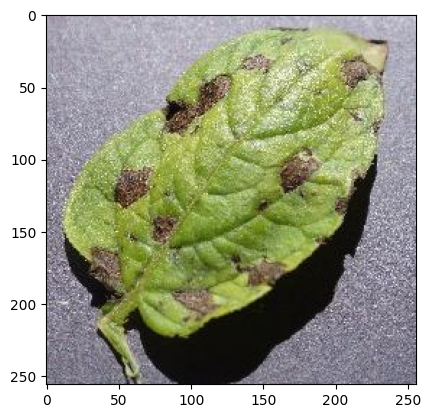

In [8]:
print(len(train_dataset), len(test_dataset))
plot_random_image(dataset=test_dataset)

# Define the model, optimizer and loss function

In [9]:
vgg = vgg19()

n_classes = len(train_dataset.dataset.classes)
vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=n_classes)

print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


In [10]:
optimizer = torch.optim.Adam(params=vgg.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop

In [11]:
def train_model(model, dataloader, loss_fn, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        for batch, (images, labels) in tqdm(enumerate(dataloader)):
            logits = model(images.to(device))
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            if batch % 10 == 0:
                print(f"loss for batch {batch} --> {loss} at epoch {epoch}") 
                
    print(f"loss for the very last batch --> {loss}")

In [12]:
train_model(model=vgg, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=5)

1it [00:01,  1.38s/it]

loss for batch 0 --> 1.0842633247375488 at epoch 0


11it [00:06,  2.02it/s]

loss for batch 10 --> 0.8670039176940918 at epoch 0


21it [00:11,  2.04it/s]

loss for batch 20 --> 1.0052095651626587 at epoch 0


31it [00:15,  2.07it/s]

loss for batch 30 --> 0.9477688670158386 at epoch 0


41it [00:20,  2.02it/s]

loss for batch 40 --> 0.8469257354736328 at epoch 0


51it [00:25,  2.05it/s]

loss for batch 50 --> 0.866618812084198 at epoch 0


54it [00:27,  1.99it/s]
1it [00:00,  2.44it/s]

loss for batch 0 --> 0.8379167914390564 at epoch 1


11it [00:04,  2.42it/s]

loss for batch 10 --> 1.0043103694915771 at epoch 1


21it [00:08,  2.46it/s]

loss for batch 20 --> 0.81332927942276 at epoch 1


31it [00:12,  2.44it/s]

loss for batch 30 --> 0.9564499855041504 at epoch 1


41it [00:16,  2.47it/s]

loss for batch 40 --> 0.7536407113075256 at epoch 1


51it [00:20,  2.46it/s]

loss for batch 50 --> 0.667036235332489 at epoch 1


54it [00:21,  2.47it/s]
1it [00:00,  2.42it/s]

loss for batch 0 --> 0.7057069540023804 at epoch 2


11it [00:04,  2.46it/s]

loss for batch 10 --> 0.7265562415122986 at epoch 2


21it [00:08,  2.47it/s]

loss for batch 20 --> 0.5613580346107483 at epoch 2


31it [00:12,  2.45it/s]

loss for batch 30 --> 0.4344959557056427 at epoch 2


41it [00:16,  2.46it/s]

loss for batch 40 --> 0.2773694694042206 at epoch 2


51it [00:20,  2.43it/s]

loss for batch 50 --> 0.3123847246170044 at epoch 2


54it [00:21,  2.47it/s]
1it [00:00,  2.36it/s]

loss for batch 0 --> 0.36932459473609924 at epoch 3


11it [00:04,  2.43it/s]

loss for batch 10 --> 0.46746745705604553 at epoch 3


21it [00:08,  2.45it/s]

loss for batch 20 --> 0.433728963136673 at epoch 3


31it [00:12,  2.43it/s]

loss for batch 30 --> 0.30596962571144104 at epoch 3


41it [00:16,  2.44it/s]

loss for batch 40 --> 0.20399925112724304 at epoch 3


51it [00:20,  2.44it/s]

loss for batch 50 --> 0.1382150799036026 at epoch 3


54it [00:22,  2.45it/s]
1it [00:00,  2.44it/s]

loss for batch 0 --> 0.25899189710617065 at epoch 4


11it [00:04,  2.45it/s]

loss for batch 10 --> 0.11696185171604156 at epoch 4


21it [00:08,  2.46it/s]

loss for batch 20 --> 0.26726409792900085 at epoch 4


31it [00:12,  2.46it/s]

loss for batch 30 --> 0.2813091278076172 at epoch 4


41it [00:16,  2.46it/s]

loss for batch 40 --> 0.16292402148246765 at epoch 4


51it [00:20,  2.46it/s]

loss for batch 50 --> 0.10505971312522888 at epoch 4


54it [00:21,  2.47it/s]

loss for the very last batch --> 0.31240373849868774


# Model inference

In [13]:
def pred_random_image(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image_tensor = dataset[x][0]
    image_label = dataset[x][1]
    plot_image(image_tensor.cpu())
    
    print(f"label is --> {image_label} ({dataset.dataset.classes[image_label]})")

    model.eval()
    with torch.inference_mode():
        image_tensor = image_tensor.to(device)
        logits = model(image_tensor.unsqueeze(dim=0))
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)

        print(f"model predicted --> {dataset.dataset.classes[pred.item()]}")

label is --> 1 (Potato___Late_blight)
model predicted --> Potato___healthy


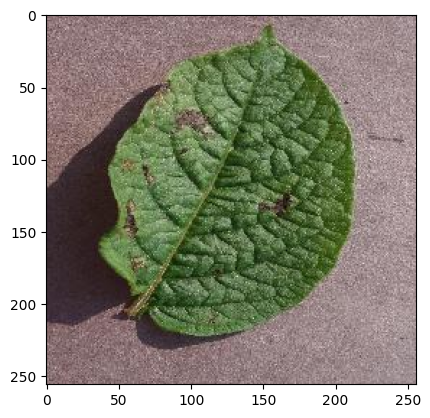

In [14]:
pred_random_image(model=vgg, dataset=test_dataset)